### K√ºt√ºphaneleri y√ºkle

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, hamming_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# BERT i√ßin gerekli k√ºt√ºphaneler
try:
    from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
    from transformers import EarlyStoppingCallback, get_linear_schedule_with_warmup
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset, Dataset
    from torch.optim import AdamW
    BERT_AVAILABLE = True
    print("‚úì BERT k√ºt√ºphaneleri ve fine-tuning ara√ßlarƒ± y√ºklendi")
except ImportError:
    BERT_AVAILABLE = False
    print("‚ö†Ô∏è BERT k√ºt√ºphaneleri bulunamadƒ±. Sadece sklearn modelleri kullanƒ±lacak.")


‚úì BERT k√ºt√ºphaneleri ve fine-tuning ara√ßlarƒ± y√ºklendi


### Parametreleri ayarla

In [3]:
print("OneVsRestClassifier ile: Logistic Regression + SVM + Random Forest + BERT Fine-tuning\n")

# TF-IDF parametreleri
max_features = 50000
ngram_range = (1, 2)
min_df = 2
max_df = 0.95

OneVsRestClassifier ile: Logistic Regression + SVM + Random Forest + BERT Fine-tuning



In [4]:
# Model eƒüitim parametreleri
test_size = 0.2
random_state = 42

In [5]:
print(f"Vekt√∂rle≈ütirme Parametreleri:")
print(f"- Max Features: {max_features}")
print(f"- N-gram Range: {ngram_range}")
print(f"- Min DF: {min_df}")
print(f"- Max DF: {max_df}")

Vekt√∂rle≈ütirme Parametreleri:
- Max Features: 50000
- N-gram Range: (1, 2)
- Min DF: 2
- Max DF: 0.95


###  Metin √∂n i≈üleme fonksiyonu

In [6]:
def text_preprocessing(text):
    """Metin √∂n i≈üleme fonksiyonu - pickle edilebilir versiyon"""
    if pd.notna(text):
        # K√º√ß√ºk harfe √ßevir ve √∂zel karakterleri temizle
        cleaned = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Fazla bo≈üluklarƒ± temizle
        return ' '.join(cleaned.split())
    else:
        return ""

print("Metin √∂n i≈üleme fonksiyonu hazƒ±rlandƒ±.")

Metin √∂n i≈üleme fonksiyonu hazƒ±rlandƒ±.


### Geli≈ümi≈ü Model Sƒ±nƒ±flarƒ±

In [7]:
# Korelasyon-farkƒ±nda kayƒ±p fonksiyonu sƒ±nƒ±fƒ±
class CorrelationAwareLoss:
    """Korelasyon-farkƒ±nda kayƒ±p fonksiyonlarƒ±"""
    
    @staticmethod
    def pairwise_ranking_loss(y_true, y_pred, margin=1.0):
        """Pairwise Ranking Loss - korelasyonlu etiketler i√ßin"""
        loss = 0.0
        n_samples, n_labels = y_true.shape
        
        for i in range(n_samples):
            # Pozitif ve negatif etiketleri ayƒ±r
            pos_indices = np.where(y_true[i] == 1)[0]
            neg_indices = np.where(y_true[i] == 0)[0]
            
            # Her pozitif-negatif √ßifti i√ßin ranking loss hesapla
            for pos_idx in pos_indices:
                for neg_idx in neg_indices:
                    # Pozitif etiketin skoru negatiften b√ºy√ºk olmalƒ±
                    diff = y_pred[i, neg_idx] - y_pred[i, pos_idx] + margin
                    if diff > 0:
                        loss += diff
        
        return loss / n_samples if n_samples > 0 else 0.0
    
    @staticmethod
    def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
        """Focal Loss - dengesiz etiketler i√ßin"""
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        
        # Pozitif sƒ±nƒ±flar i√ßin focal loss
        pos_loss = -alpha * (1 - y_pred) ** gamma * y_true * np.log(y_pred)
        
        # Negatif sƒ±nƒ±flar i√ßin focal loss
        neg_loss = -(1 - alpha) * y_pred ** gamma * (1 - y_true) * np.log(1 - y_pred)
        
        return np.mean(pos_loss + neg_loss)

In [8]:
# Probabilistic Classifier Chain sƒ±nƒ±fƒ±
class ProbabilisticClassifierChain(BaseEstimator, ClassifierMixin):
    """Probabilistic Classifier Chain - belirsizlik modelleme ile"""
    
    def __init__(self, base_estimator, order=None, random_state=None):
        self.base_estimator = base_estimator
        self.order = order
        self.random_state = random_state
        
    def fit(self, X, Y):
        """Modeli eƒüit"""
        X, Y = check_X_y(X, Y, multi_output=True, accept_sparse=True)
        
        self.classes_ = []
        self.estimators_ = []
        self.n_labels_ = Y.shape[1]
        
        # Etiket sƒ±rasƒ±nƒ± belirle
        if self.order is None:
            # Korelasyon bazlƒ± sƒ±ralama
            corr_matrix = np.corrcoef(Y.T)
            # En y√ºksek ortalama korelasyona sahip etiketleri √∂nce al
            mean_corr = np.nanmean(np.abs(corr_matrix), axis=1)
            self.order_ = np.argsort(-mean_corr)
        else:
            self.order_ = self.order
            
        # Her etiket i√ßin bir estimator eƒüit
        for i, label_idx in enumerate(self.order_):
            y = Y[:, label_idx]
            self.classes_.append(unique_labels(y))
            
            # √ñnceki etiketlerin tahminlerini √∂zellik olarak ekle
            if i == 0:
                X_extended = X
            else:
                # √ñnceki etiketlerin ger√ßek deƒüerlerini kullan (eƒüitim sƒ±rasƒ±nda)
                prev_labels = Y[:, self.order_[:i]]
                if hasattr(X, 'toarray'):
                    X_extended = np.hstack([X.toarray(), prev_labels])
                else:
                    X_extended = np.hstack([X, prev_labels])
            
            # Estimator'ƒ± kopyala ve eƒüit
            estimator = pickle.loads(pickle.dumps(self.base_estimator))
            estimator.fit(X_extended, y)
            self.estimators_.append(estimator)
            
        return self
    
    def predict(self, X):
        """Tahmin yap"""
        check_is_fitted(self)
        X = check_array(X, accept_sparse=True)
        
        n_samples = X.shape[0]
        Y_pred = np.zeros((n_samples, self.n_labels_))
        
        # Sƒ±ralƒ± tahmin
        for i, (label_idx, estimator) in enumerate(zip(self.order_, self.estimators_)):
            if i == 0:
                X_extended = X
            else:
                # √ñnceki tahminleri √∂zellik olarak kullan
                prev_preds = Y_pred[:, self.order_[:i]]
                if hasattr(X, 'toarray'):
                    X_extended = np.hstack([X.toarray(), prev_preds])
                else:
                    X_extended = np.hstack([X, prev_preds])
            
            Y_pred[:, label_idx] = estimator.predict(X_extended)
            
        return Y_pred.astype(int)
    
    def predict_proba(self, X):
        """Olasƒ±lƒ±k tahminleri"""
        check_is_fitted(self)
        X = check_array(X, accept_sparse=True)
        
        n_samples = X.shape[0]
        Y_proba = np.zeros((n_samples, self.n_labels_))
        
        for i, (label_idx, estimator) in enumerate(zip(self.order_, self.estimators_)):
            if i == 0:
                X_extended = X
            else:
                # Monte Carlo sampling ile belirsizlik modelle
                prev_preds = Y_proba[:, self.order_[:i]]
                if hasattr(X, 'toarray'):
                    X_extended = np.hstack([X.toarray(), prev_preds])
                else:
                    X_extended = np.hstack([X, prev_preds])
            
            if hasattr(estimator, 'predict_proba'):
                proba = estimator.predict_proba(X_extended)
                if proba.shape[1] == 2:
                    Y_proba[:, label_idx] = proba[:, 1]
                else:
                    Y_proba[:, label_idx] = proba[:, 0]
            else:
                # Eƒüer predict_proba yoksa decision_function kullan
                if hasattr(estimator, 'decision_function'):
                    scores = estimator.decision_function(X_extended)
                    Y_proba[:, label_idx] = 1 / (1 + np.exp(-scores))  # Sigmoid
                else:
                    Y_proba[:, label_idx] = estimator.predict(X_extended)
                    
        return Y_proba

#### BERT Model Sƒ±nƒ±flarƒ± ve Fine-tuning (eƒüer BERT kullanƒ±labilirse)

In [9]:
 # √ñzel Dataset sƒ±nƒ±fƒ±
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


In [10]:
# Geli≈ümi≈ü BERT Multi-Label Classifier
class BERTMultiLabelClassifier(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', num_labels=49, dropout_rate=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        # √áoklu katmanlƒ± classifier
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, num_labels)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] token + mean pooling
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        mean_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean pooling
        combined = (cls_output + mean_output) / 2  # Ortalama al
        
        output = self.dropout(combined)
        logits = self.classifier(output)
        return self.sigmoid(logits)

In [11]:
# Fine-tuning Trainer sƒ±nƒ±fƒ±
class BERTFineTuner:
    def __init__(self, model_name='distilbert-base-uncased', num_labels=49, device=None):
        self.model_name = model_name
        self.num_labels = num_labels
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.tokenizer = None
        
    def prepare_model(self):
        """Model ve tokenizer'ƒ± hazƒ±rla"""
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = BERTMultiLabelClassifier(self.model_name, self.num_labels)
        self.model.to(self.device)
        
    def train(self, train_texts, train_labels, val_texts=None, val_labels=None, 
             epochs=3, batch_size=16, learning_rate=2e-5, warmup_steps=500):
        """Fine-tuning i≈ülemi"""
        if self.model is None:
            self.prepare_model()
        
        # Dataset'leri hazƒ±rla
        train_dataset = MultiLabelDataset(train_texts, train_labels, self.tokenizer)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        if val_texts is not None and val_labels is not None:
            val_dataset = MultiLabelDataset(val_texts, val_labels, self.tokenizer)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        else:
            val_loader = None
        
        # Optimizer ve scheduler
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
        )
        
        # Loss fonksiyonu (weighted binary cross entropy)
        criterion = nn.BCELoss()
        
        # Eƒüitim d√∂ng√ºs√º
        best_val_loss = float('inf')
        patience = 2
        patience_counter = 0
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            
            # Eƒüitim
            self.model.train()
            total_train_loss = 0
            
            for batch_idx, batch in enumerate(train_loader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                total_train_loss += loss.item()
                
                if batch_idx % 50 == 0:
                    print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
            
            avg_train_loss = total_train_loss / len(train_loader)
            print(f"  Ortalama eƒüitim kaybƒ±: {avg_train_loss:.4f}")
            
            # Validation
            if val_loader:
                self.model.eval()
                total_val_loss = 0
                
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels = batch['labels'].to(self.device)
                        
                        outputs = self.model(input_ids, attention_mask)
                        loss = criterion(outputs, labels)
                        total_val_loss += loss.item()
                
                avg_val_loss = total_val_loss / len(val_loader)
                print(f"  Validation kaybƒ±: {avg_val_loss:.4f}")
                
                # Early stopping
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"  Early stopping! En iyi validation loss: {best_val_loss:.4f}")
                        break
        
        return self.model
    
    def predict(self, texts, batch_size=32):
        """Tahmin yap"""
        if self.model is None:
            raise ValueError("Model hen√ºz eƒüitilmedi!")
        
        dataset = MultiLabelDataset(texts, [[0] * self.num_labels] * len(texts), self.tokenizer)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        self.model.eval()
        predictions = []
        probabilities = []
        
        with torch.no_grad():
            for batch in loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                outputs = self.model(input_ids, attention_mask)
                probs = outputs.cpu().numpy()
                preds = (probs > 0.5).astype(int)
                
                predictions.extend(preds)
                probabilities.extend(probs)
        
        return np.array(predictions), np.array(probabilities)

In [12]:
# Korelasyon-farkƒ±nda BERT Loss
class CorrelationAwareBERTLoss(nn.Module):
    def __init__(self, correlation_matrix, alpha=0.1):
        super().__init__()
        self.correlation_matrix = torch.tensor(correlation_matrix, dtype=torch.float32)
        self.alpha = alpha
        self.bce_loss = nn.BCELoss()
        
    def forward(self, predictions, targets):
        # Standart BCE loss
        bce = self.bce_loss(predictions, targets)
        
        # Korelasyon penalty
        corr_penalty = 0.0
        batch_size, n_labels = predictions.shape
        
        for i in range(n_labels):
            for j in range(i+1, n_labels):
                if abs(self.correlation_matrix[i, j]) > 0.3:  # Y√ºksek korelasyon
                    # Korelasyonlu etiketlerin tahminleri tutarlƒ± olmalƒ±
                    pred_diff = torch.abs(predictions[:, i] - predictions[:, j])
                    target_diff = torch.abs(targets[:, i] - targets[:, j])
                    corr_penalty += torch.mean(torch.abs(pred_diff - target_diff))
        
        return bce + self.alpha * corr_penalty

### Veri setini y√ºkle ve hazƒ±rla

In [13]:
print("\nVeri seti y√ºkleniyor...")
df = pd.read_csv('preprocessed_dataset_3.csv')
print(f"Orijinal veri seti boyutu: {df.shape}")


Veri seti y√ºkleniyor...
Orijinal veri seti boyutu: (158804, 5)


In [14]:
# Text s√ºtununu √∂n i≈üle
print("Metin √∂n i≈üleme yapƒ±lƒ±yor...")
df['text'] = df['text'].apply(text_preprocessing)

Metin √∂n i≈üleme yapƒ±lƒ±yor...


In [15]:
# Bo≈ü metinleri filtrele
df = df[df['text'].str.len() > 0].reset_index(drop=True)

In [16]:
# Etiket s√ºtunlarƒ±nƒ± belirle
label_columns = [col for col in df.columns if col != 'text']

In [17]:
print(f"Etiket sayƒ±sƒ±: {len(label_columns)}")
print(f"Temizlenmi≈ü veri boyutu: {df.shape}")

Etiket sayƒ±sƒ±: 4
Temizlenmi≈ü veri boyutu: (158804, 5)


In [18]:
# Veri boyutunu sƒ±nƒ±rla (BERT i√ßin)
if len(df) > 50000:
    print(f"Veri seti {len(df)} satƒ±r. BERT eƒüitimi i√ßin ilk 50000 satƒ±r kullanƒ±lacak.")
    df = df.head(50000).copy()


Veri seti 158804 satƒ±r. BERT eƒüitimi i√ßin ilk 50000 satƒ±r kullanƒ±lacak.


### Sƒ±nƒ±f daƒüƒ±lƒ±mƒ±nƒ± analiz et

In [19]:
# √ñzellik ve etiketleri ayƒ±r
X = df['text']
y = df[label_columns]

In [20]:
label_sums = y.sum(axis=0)
min_samples = label_sums.min()
max_samples = label_sums.max()

In [21]:
print(f"En az √∂rnek: {min_samples}")
print(f"En √ßok √∂rnek: {max_samples}")
print(f"Dengesizlik oranƒ±: {max_samples/min_samples:.2f}")

En az √∂rnek: 11847
En √ßok √∂rnek: 23289
Dengesizlik oranƒ±: 1.97


In [22]:
# Daƒüƒ±lƒ±m DataFrame'i
distribution_df = pd.DataFrame({
    'label': label_columns,
    'count': label_sums,
    'percentage': (label_sums / len(y)) * 100
}).sort_values('count')

In [23]:
print("\nEn az √∂rnekli 5 etiket:")
print(distribution_df.head())
print("\nEn √ßok √∂rnekli 5 etiket:")
print(distribution_df.tail())


En az √∂rnekli 5 etiket:
                                 label  count  percentage
Pazarlar & Ticaret  Pazarlar & Ticaret  11847      23.694
H√ºk√ºmet & Sosyal      H√ºk√ºmet & Sosyal  15906      31.812
Ekonomi & Finans      Ekonomi & Finans  18506      37.012
ƒ∞≈ü & End√ºstri            ƒ∞≈ü & End√ºstri  23289      46.578

En √ßok √∂rnekli 5 etiket:
                                 label  count  percentage
Pazarlar & Ticaret  Pazarlar & Ticaret  11847      23.694
H√ºk√ºmet & Sosyal      H√ºk√ºmet & Sosyal  15906      31.812
Ekonomi & Finans      Ekonomi & Finans  18506      37.012
ƒ∞≈ü & End√ºstri            ƒ∞≈ü & End√ºstri  23289      46.578


### Korelasyon Analizi

In [24]:
# Etiketler arasƒ± korelasyon matrisini hesapla
correlation_matrix = y.corr()
print(f"Korelasyon matrisi boyutu: {correlation_matrix.shape}")

Korelasyon matrisi boyutu: (4, 4)


In [25]:
# Y√ºksek korelasyonlu etiket √ßiftlerini bul
high_corr_pairs = []
threshold = 0.3  # Korelasyon e≈üiƒüi

In [26]:
for i in range(len(label_columns)):
    for j in range(i+1, len(label_columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'label1': label_columns[i],
                'label2': label_columns[j],
                'correlation': corr_val
            })

In [27]:
# Y√ºksek korelasyonlu √ßiftleri sƒ±rala
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)


In [28]:
print(f"\nY√ºksek korelasyonlu etiket √ßiftleri (|r| > {threshold}):")
print(f"Toplam {len(high_corr_pairs)} √ßift bulundu")



Y√ºksek korelasyonlu etiket √ßiftleri (|r| > 0.3):
Toplam 5 √ßift bulundu


In [29]:
if high_corr_pairs:
    print("\nEn y√ºksek korelasyonlu 10 √ßift:")
    for i, pair in enumerate(high_corr_pairs[:10]):
        print(f"{i+1}. {pair['label1']} - {pair['label2']}: {pair['correlation']:.3f}")



En y√ºksek korelasyonlu 10 √ßift:
1. Ekonomi & Finans - Pazarlar & Ticaret: 0.725
2. Ekonomi & Finans - ƒ∞≈ü & End√ºstri: -0.442
3. H√ºk√ºmet & Sosyal - ƒ∞≈ü & End√ºstri: -0.387
4. Pazarlar & Ticaret - ƒ∞≈ü & End√ºstri: -0.373
5. H√ºk√ºmet & Sosyal - Pazarlar & Ticaret: -0.343


In [30]:
# Ortalama korelasyon deƒüerlerini hesapla
all_correlations = []
for i in range(len(label_columns)):
    for j in range(i+1, len(label_columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if not np.isnan(corr_val):
            all_correlations.append(abs(corr_val))

In [31]:
if all_correlations:
    mean_corr = np.mean(all_correlations)
    max_corr = np.max(all_correlations)
    print(f"\nOrtalama mutlak korelasyon: {mean_corr:.3f}")
    print(f"Maksimum mutlak korelasyon: {max_corr:.3f}")


Ortalama mutlak korelasyon: 0.428
Maksimum mutlak korelasyon: 0.725


In [32]:
# Korelasyon matrisini g√∂rselle≈ütir (en √ßok kullanƒ±lan 15 etiket i√ßin)
if len(label_columns) > 15:
    top_labels = distribution_df.tail(15)['label'].tolist()
    corr_subset = y[top_labels].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))
    sns.heatmap(corr_subset, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, 
                fmt='.2f', annot_kws={'size': 8})
    plt.title('En √áok Kullanƒ±lan 15 Etiket Arasƒ± Korelasyon Matrisi', fontsize=14)
    plt.tight_layout()
    plt.savefig('label_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Korelasyon matrisi 'label_correlations.png' olarak kaydedildi")

### Train-test split

In [33]:
print("\nVeri seti ayrƒ±lƒ±yor...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=None
)


Veri seti ayrƒ±lƒ±yor...


In [34]:
print(f"Eƒüitim seti boyutu: {len(X_train)}")
print(f"Test seti boyutu: {len(X_test)}")

Eƒüitim seti boyutu: 40000
Test seti boyutu: 10000


### TF-IDF vekt√∂rle≈ütirme

In [35]:
# TF-IDF vekt√∂rle≈ütirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    min_df=min_df,
    max_df=max_df,
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

In [36]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [37]:
print(f"TF-IDF √∂zellik boyutu: {X_train_tfidf.shape[1]}")

TF-IDF √∂zellik boyutu: 50000


### Model 1: OneVsRestClassifier ile Logistic Regression

In [38]:
start_time = time.time()

lr_base_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [39]:
lr_ovr_model = OneVsRestClassifier(lr_base_model, n_jobs=-1)
lr_ovr_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, random_state=42,
                                                 solver='liblinear'),
                    n_jobs=-1)

In [40]:
lr_ovr_train_time = time.time() - start_time
print(f"OneVsRest Logistic Regression eƒüitim s√ºresi: {lr_ovr_train_time:.2f} saniye")


OneVsRest Logistic Regression eƒüitim s√ºresi: 5.74 saniye


In [41]:
# OneVsRest Logistic Regression tahminleri
print("OneVsRest Logistic Regression tahminleri yapƒ±lƒ±yor...")
lr_ovr_pred = lr_ovr_model.predict(X_test_tfidf)

OneVsRest Logistic Regression tahminleri yapƒ±lƒ±yor...


####  Model 1b: MultiOutputClassifier ile Logistic Regression (kar≈üƒ±la≈ütƒ±rma i√ßin)

In [42]:
start_time = time.time()

lr_base_model_multi = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [43]:

lr_multi_model = MultiOutputClassifier(lr_base_model_multi, n_jobs=-1)
lr_multi_model.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42,
                                                   solver='liblinear'),
                      n_jobs=-1)

In [44]:
lr_multi_train_time = time.time() - start_time
print(f"MultiOutput Logistic Regression eƒüitim s√ºresi: {lr_multi_train_time:.2f} saniye")


MultiOutput Logistic Regression eƒüitim s√ºresi: 4.79 saniye


In [45]:
# MultiOutput Logistic Regression tahminleri
print("MultiOutput Logistic Regression tahminleri yapƒ±lƒ±yor...")
lr_multi_pred = lr_multi_model.predict(X_test_tfidf)


MultiOutput Logistic Regression tahminleri yapƒ±lƒ±yor...


###  Model 2: OneVsRestClassifier ile SVM

In [46]:
start_time = time.time()

svm_base_model = SVC(
    kernel='linear',
    class_weight='balanced', 
    probability=False,  # Olasƒ±lƒ±k hesaplamasƒ± yapƒ±lmayacak
    random_state=random_state,
    max_iter=500,
    cache_size=2000,  # Cache boyutunu artƒ±r
    shrinking=True  # Shrinking heuristiƒüi aktif
)


In [47]:
# Paralelle≈ütirme olmadan eƒüit (salt okunur hatasƒ± √∂nlemek i√ßin)
svm_ovr_model = OneVsRestClassifier(svm_base_model, n_jobs=None)
svm_ovr_model.fit(X_train_tfidf, y_train)


OneVsRestClassifier(estimator=SVC(cache_size=2000, class_weight='balanced',
                                  kernel='linear', max_iter=500,
                                  random_state=42))

In [48]:
svm_ovr_train_time = time.time() - start_time
print(f"OneVsRest SVM eƒüitim s√ºresi: {svm_ovr_train_time:.2f} saniye")

OneVsRest SVM eƒüitim s√ºresi: 126.79 saniye


In [49]:
# OneVsRest SVM tahminleri
print("OneVsRest SVM tahminleri yapƒ±lƒ±yor...")
svm_ovr_pred = svm_ovr_model.predict(X_test_tfidf)

OneVsRest SVM tahminleri yapƒ±lƒ±yor...


In [ ]:
# OneVsRest SVM sonu√ßlarƒ±
print("\n=== OneVsRest SVM Sonu√ßlarƒ± ===")

# Genel performans metrikleri
accuracy = accuracy_score(y_test, svm_ovr_pred)
hamming = hamming_loss(y_test, svm_ovr_pred)

print(f"Subset Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")


### Model 3: OneVsRestClassifier ile Random Forest

In [50]:
start_time = time.time()

rf_base_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

In [51]:
rf_ovr_model = OneVsRestClassifier(rf_base_model, n_jobs=-1)
rf_ovr_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20, n_jobs=-1,
                                                     random_state=42),
                    n_jobs=-1)

In [52]:
rf_ovr_train_time = time.time() - start_time
print(f"OneVsRest Random Forest eƒüitim s√ºresi: {rf_ovr_train_time:.2f} saniye")

OneVsRest Random Forest eƒüitim s√ºresi: 19.12 saniye


In [53]:
# OneVsRest Random Forest tahminleri
print("OneVsRest Random Forest tahminleri yapƒ±lƒ±yor...")
rf_ovr_pred = rf_ovr_model.predict(X_test_tfidf)

OneVsRest Random Forest tahminleri yapƒ±lƒ±yor...


In [123]:
# OneVsRest Random Forest sonu√ßlarƒ±
print("\n=== OneVsRest Random Forest Sonu√ßlarƒ± ===")

# Genel performans metrikleri
accuracy = accuracy_score(y_test, rf_ovr_pred)
hamming = hamming_loss(y_test, rf_ovr_pred)

print(f"Subset Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")




=== OneVsRest Random Forest Sonu√ßlarƒ± ===
Subset Accuracy: 0.7827
Hamming Loss: 0.0757


####  Model 3b: MultiOutputClassifier ile Random Forest (kar≈üƒ±la≈ütƒ±rma i√ßin)

In [54]:
start_time = time.time()

rf_base_model_multi = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

In [55]:
rf_multi_model = MultiOutputClassifier(rf_base_model_multi, n_jobs=-1)
rf_multi_model.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20, n_jobs=-1,
                                                       random_state=42),
                      n_jobs=-1)

In [56]:
rf_multi_train_time = time.time() - start_time
print(f"MultiOutput Random Forest eƒüitim s√ºresi: {rf_multi_train_time:.2f} saniye")


MultiOutput Random Forest eƒüitim s√ºresi: 21.22 saniye


In [57]:
# MultiOutput Random Forest tahminleri
print("MultiOutput Random Forest tahminleri yapƒ±lƒ±yor...")
rf_multi_pred = rf_multi_model.predict(X_test_tfidf)

MultiOutput Random Forest tahminleri yapƒ±lƒ±yor...


In [ ]:
# MultiOutput Random Forest sonu√ßlarƒ±
print("\n=== MultiOutput Random Forest Sonu√ßlarƒ± ===")

# Genel performans metrikleri
accuracy = accuracy_score(y_test, rf_multi_pred)
hamming = hamming_loss(y_test, rf_multi_pred)

print(f"Subset Accuracy: {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

# Her sƒ±nƒ±f i√ßin performans metrikleri
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(rf_multi_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        # Pozitif ve negatif √∂rnek sayƒ±larƒ±
        pos_samples = int(np.sum(y_true_col))
        neg_samples = len(y_true_col) - pos_samples
        
        # Confusion matrix elemanlarƒ±
        tp = int(np.sum((y_true_col == 1) & (y_pred_col == 1)))
        fp = int(np.sum((y_true_col == 0) & (y_pred_col == 1)))
        fn = int(np.sum((y_true_col == 1) & (y_pred_col == 0)))
        tn = int(np.sum((y_true_col == 0) & (y_pred_col == 0)))
        
        print(f"\n{label} sƒ±nƒ±fƒ± i√ßin:")
        print(f"Doƒüruluk (Accuracy): {accuracy:.4f}")
        print(f"Kesinlik (Precision): {precision:.4f}")
        print(f"Duyarlƒ±lƒ±k (Recall): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pozitif √∂rnekler: {pos_samples:4d}, Negatif √∂rnekler: {neg_samples:4d}")
        print(f"TP: {tp:3d}, FP: {fp:3d}, FN: {fn:3d}, TN: {tn:4d}")
        
    except Exception as e:
        print(f"\n{label} sƒ±nƒ±fƒ± i√ßin hata: {str(e)}")
        continue


# T√ºm etiketler i√ßin ortalama performans
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(rf_multi_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
    except:
        continue

if all_f1s:  # Eƒüer ba≈üarƒ±lƒ± hesaplamalar varsa
    print(f"Ortalama Accuracy: {np.mean(all_accuracies):.4f}")
    print(f"Ortalama Precision: {np.mean(all_precisions):.4f}")
    print(f"Ortalama Recall: {np.mean(all_recalls):.4f}")
    print(f"Ortalama F1-Score: {np.mean(all_f1s):.4f}")
    
    # En iyi ve en k√∂t√º performans g√∂steren etiketler
    f1_with_labels = list(zip(label_columns, all_f1s))
    f1_with_labels.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nEn iyi F1 skoruna sahip 4 etiket:")
    for i, (label, f1_score) in enumerate(f1_with_labels[:5]):
        print(f"{i+1}. {label}: {f1_score:.4f}")
    
    print(f"\nEn d√º≈ü√ºk F1 skoruna sahip 4 etiket:")
    for i, (label, f1_score) in enumerate(f1_with_labels[-5:]):
        print(f"{i+1}. {label}: {f1_score:.4f}")

#### Model 2a: Classifier Chain (Logistic Regression)

In [114]:
start_time = time.time()

# Korelasyon bazlƒ± sƒ±ralama kullan
if len(high_corr_pairs) > 0:
    # Y√ºksek korelasyonlu etiketleri √∂nce al
    corr_labels = set()
    for pair in high_corr_pairs[:10]:  # En y√ºksek 10 √ßifti al
        corr_labels.add(pair['label1'])
        corr_labels.add(pair['label2'])
    
    # Korelasyonlu etiketleri √∂nce, diƒüerlerini sonra sƒ±rala
    corr_order = []
    remaining_labels = []
    for i, label in enumerate(label_columns):
        if label in corr_labels:
            corr_order.append(i)
        else:
            remaining_labels.append(i)
    
    chain_order = corr_order + remaining_labels
else:
    chain_order = None

In [59]:

cc_lr_base_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [60]:
cc_lr_model = ClassifierChain(cc_lr_base_model, order=chain_order, random_state=random_state)
cc_lr_model.fit(X_train_tfidf, y_train)


ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                  max_iter=1000,
                                                  random_state=42,
                                                  solver='liblinear'),
                order=[0, 1, 2, 3], random_state=42)

In [61]:
cc_lr_train_time = time.time() - start_time
print(f"Classifier Chain (LR) eƒüitim s√ºresi: {cc_lr_train_time:.2f} saniye")


Classifier Chain (LR) eƒüitim s√ºresi: 5.22 saniye


In [62]:
# Classifier Chain tahminleri
print("Classifier Chain (LR) tahminleri yapƒ±lƒ±yor...")
cc_lr_pred = cc_lr_model.predict(X_test_tfidf)

Classifier Chain (LR) tahminleri yapƒ±lƒ±yor...


In [113]:
# Classifier Chain sonu√ßlarƒ±
print("\n=== Classifier Chain (LR) Sonu√ßlarƒ± ===")

# Subset accuracy
accuracy = accuracy_score(y_test, cc_lr_pred)
print(f"Subset Accuracy: {accuracy:.4f}")

# Hamming loss
hamming = hamming_loss(y_test, cc_lr_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Micro ve macro ortalama metrikler
precision_micro = precision_score(y_test, cc_lr_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, cc_lr_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, cc_lr_pred, average='micro', zero_division=0)

precision_macro = precision_score(y_test, cc_lr_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, cc_lr_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, cc_lr_pred, average='macro', zero_division=0)

print("\nMicro-averaged sonu√ßlar:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-score: {f1_micro:.4f}")

print("\nMacro-averaged sonu√ßlar:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-score: {f1_macro:.4f}")

# Her bir etiket i√ßin detaylƒ± sonu√ßlar
print("\nEtiket bazƒ±nda sonu√ßlar:")
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(cc_lr_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        print(f"\n{label}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        
    except Exception as e:
        print(f"\n{label} i√ßin hata: {str(e)}")
        continue



=== Classifier Chain (LR) Sonu√ßlarƒ± ===
Subset Accuracy: 0.8400
Hamming Loss: 0.0600

Micro-averaged sonu√ßlar:
Precision: 0.9117
Recall: 0.9163
F1-score: 0.9140

Macro-averaged sonu√ßlar:
Precision: 0.9051
Recall: 0.9249
F1-score: 0.9133

Etiket bazƒ±nda sonu√ßlar:

H√ºk√ºmet & Sosyal:
Accuracy: 0.9559
Precision: 0.9140
Recall: 0.9462
F1-score: 0.9298

Ekonomi & Finans:
Accuracy: 0.9362
Precision: 0.9103
Recall: 0.9191
F1-score: 0.9146

Pazarlar & Ticaret:
Accuracy: 0.9469
Precision: 0.8379
Recall: 0.9630
F1-score: 0.8961

ƒ∞≈ü & End√ºstri:
Accuracy: 0.9210
Precision: 0.9582
Recall: 0.8712
F1-score: 0.9126


#### Model 2b: Probabilistic Classifier Chain

In [63]:
start_time = time.time()

pcc_base_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=random_state,
    solver='liblinear'
)

In [64]:

pcc_model = ProbabilisticClassifierChain(pcc_base_model, random_state=random_state)
pcc_model.fit(X_train_tfidf, y_train.values)


ProbabilisticClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                               max_iter=1000,
                                                               random_state=42,
                                                               solver='liblinear'),
                             random_state=42)

In [65]:
pcc_train_time = time.time() - start_time
print(f"Probabilistic Classifier Chain eƒüitim s√ºresi: {pcc_train_time:.2f} saniye")


Probabilistic Classifier Chain eƒüitim s√ºresi: 420.06 saniye


In [66]:
# Probabilistic Classifier Chain tahminleri
print("Probabilistic Classifier Chain tahminleri yapƒ±lƒ±yor...")
pcc_pred = pcc_model.predict(X_test_tfidf)


Probabilistic Classifier Chain tahminleri yapƒ±lƒ±yor...


In [112]:
# Probabilistic Classifier Chain sonu√ßlarƒ±
print("\n=== Probabilistic Classifier Chain Sonu√ßlarƒ± ===")

# Subset accuracy
accuracy = accuracy_score(y_test, pcc_pred)
print(f"Subset Accuracy: {accuracy:.4f}")

# Hamming loss
hamming = hamming_loss(y_test, pcc_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Micro ve macro ortalama metrikler
precision_micro = precision_score(y_test, pcc_pred, average='micro')
recall_micro = recall_score(y_test, pcc_pred, average='micro')
f1_micro = f1_score(y_test, pcc_pred, average='micro')

precision_macro = precision_score(y_test, pcc_pred, average='macro')
recall_macro = recall_score(y_test, pcc_pred, average='macro')
f1_macro = f1_score(y_test, pcc_pred, average='macro')

print("\nMicro-averaging:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-score: {f1_micro:.4f}")

print("\nMacro-averaging:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-score: {f1_macro:.4f}")

# Her bir etiket i√ßin detaylƒ± sonu√ßlar
print("\nEtiket bazƒ±nda sonu√ßlar:")
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(pcc_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        print(f"\n{label}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
    except:
        print(f"\n{label} i√ßin hesaplama yapƒ±lamadƒ±")
        continue



=== Probabilistic Classifier Chain Sonu√ßlarƒ± ===
Subset Accuracy: 0.8414
Hamming Loss: 0.0597

Micro-averaging:
Precision: 0.9111
Recall: 0.9179
F1-score: 0.9145

Macro-averaging:
Precision: 0.9048
Recall: 0.9250
F1-score: 0.9135

Etiket bazƒ±nda sonu√ßlar:

H√ºk√ºmet & Sosyal:
Accuracy: 0.9517
Precision: 0.9155
Recall: 0.9294
F1-score: 0.9224

Ekonomi & Finans:
Accuracy: 0.9367
Precision: 0.9076
Recall: 0.9239
F1-score: 0.9157

Pazarlar & Ticaret:
Accuracy: 0.9488
Precision: 0.8428
Recall: 0.9647
F1-score: 0.8996

ƒ∞≈ü & End√ºstri:
Accuracy: 0.9238
Precision: 0.9535
Recall: 0.8822
F1-score: 0.9164


#### Model 2c: Classifier Chain (Random Forest)

In [67]:
start_time = time.time()

cc_rf_base_model = RandomForestClassifier(
    n_estimators=50,  # RF i√ßin daha az aƒüa√ß (hƒ±z i√ßin)
    max_depth=15,
    class_weight='balanced',
    random_state=random_state,
    n_jobs=-1
)

In [68]:
cc_rf_model = ClassifierChain(cc_rf_base_model, order=chain_order, random_state=random_state)
cc_rf_model.fit(X_train_tfidf, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                      max_depth=15,
                                                      n_estimators=50,
                                                      n_jobs=-1,
                                                      random_state=42),
                order=[0, 1, 2, 3], random_state=42)

In [69]:
cc_rf_train_time = time.time() - start_time
print(f"Classifier Chain (RF) eƒüitim s√ºresi: {cc_rf_train_time:.2f} saniye")


Classifier Chain (RF) eƒüitim s√ºresi: 8.99 saniye


In [70]:
# Classifier Chain RF tahminleri
print("Classifier Chain (RF) tahminleri yapƒ±lƒ±yor...")
cc_rf_pred = cc_rf_model.predict(X_test_tfidf)

Classifier Chain (RF) tahminleri yapƒ±lƒ±yor...


In [111]:
# Classifier Chain RF sonu√ßlarƒ±
print("\n=== Classifier Chain (Random Forest) Sonu√ßlarƒ± ===")

# Subset accuracy
accuracy = accuracy_score(y_test, cc_rf_pred)
print(f"Subset Accuracy: {accuracy:.4f}")

# Hamming loss
hamming = hamming_loss(y_test, cc_rf_pred)
print(f"Hamming Loss: {hamming:.4f}")

# Micro ve macro ortalama metrikler
precision_micro = precision_score(y_test, cc_rf_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, cc_rf_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, cc_rf_pred, average='micro', zero_division=0)

precision_macro = precision_score(y_test, cc_rf_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, cc_rf_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, cc_rf_pred, average='macro', zero_division=0)

print("\nMicro-averaged sonu√ßlar:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-score: {f1_micro:.4f}")

print("\nMacro-averaged sonu√ßlar:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-score: {f1_macro:.4f}")

# Her sƒ±nƒ±f i√ßin detaylƒ± sonu√ßlar
print("\nSƒ±nƒ±f bazƒ±nda detaylƒ± sonu√ßlar:")
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(cc_rf_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        # Pozitif ve negatif √∂rnek sayƒ±larƒ±
        pos_samples = int(np.sum(y_true_col))
        neg_samples = len(y_true_col) - pos_samples
        
        # Confusion matrix elemanlarƒ±
        tp = int(np.sum((y_true_col == 1) & (y_pred_col == 1)))
        fp = int(np.sum((y_true_col == 0) & (y_pred_col == 1)))
        fn = int(np.sum((y_true_col == 1) & (y_pred_col == 0)))
        tn = int(np.sum((y_true_col == 0) & (y_pred_col == 0)))
        
        print(f"\n{label} sƒ±nƒ±fƒ± i√ßin:")
        print(f"Doƒüruluk (Accuracy): {accuracy:.4f}")
        print(f"Kesinlik (Precision): {precision:.4f}")
        print(f"Duyarlƒ±lƒ±k (Recall): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pozitif √∂rnekler: {pos_samples:4d}, Negatif √∂rnekler: {neg_samples:4d}")
        print(f"TP: {tp:3d}, FP: {fp:3d}, FN: {fn:3d}, TN: {tn:4d}")
        
    except Exception as e:
        print(f"\n{label} sƒ±nƒ±fƒ± i√ßin hata: {str(e)}")
        continue



=== Classifier Chain (Random Forest) Sonu√ßlarƒ± ===
Subset Accuracy: 0.7453
Hamming Loss: 0.0941

Micro-averaged sonu√ßlar:
Precision: 0.8618
Recall: 0.8689
F1-score: 0.8653

Macro-averaged sonu√ßlar:
Precision: 0.8593
Recall: 0.8717
F1-score: 0.8646

Sƒ±nƒ±f bazƒ±nda detaylƒ± sonu√ßlar:

H√ºk√ºmet & Sosyal sƒ±nƒ±fƒ± i√ßin:
Doƒüruluk (Accuracy): 0.9224
Kesinlik (Precision): 0.8903
Duyarlƒ±lƒ±k (Recall): 0.8540
F1-Score: 0.8717
Pozitif √∂rnekler: 3088, Negatif √∂rnekler: 6912
TP: 2637, FP: 325, FN: 451, TN: 6587

Ekonomi & Finans sƒ±nƒ±fƒ± i√ßin:
Doƒüruluk (Accuracy): 0.8962
Kesinlik (Precision): 0.8706
Duyarlƒ±lƒ±k (Recall): 0.8467
F1-Score: 0.8585
Pozitif √∂rnekler: 3719, Negatif √∂rnekler: 6281
TP: 3149, FP: 468, FN: 570, TN: 5813

Pazarlar & Ticaret sƒ±nƒ±fƒ± i√ßin:
Doƒüruluk (Accuracy): 0.9278
Kesinlik (Precision): 0.8092
Duyarlƒ±lƒ±k (Recall): 0.9113
F1-Score: 0.8572
Pozitif √∂rnekler: 2378, Negatif √∂rnekler: 7622
TP: 2167, FP: 511, FN: 211, TN: 7111

ƒ∞≈ü & End√ºstri sƒ±nƒ±fƒ±

Classifier Chain ile Random Forest Sonu√ßlarƒ±
------------------------------------------
- Classifier Chain, etiketler arasƒ±ndaki baƒüƒ±mlƒ±lƒ±klarƒ± modelleyerek √ßok etiketli sƒ±nƒ±flandƒ±rma yapar
- Random Forest ile birlikte kullanƒ±ldƒ±ƒüƒ±nda:
  * Aƒüa√ß yapƒ±sƒ± sayesinde doƒürusal olmayan ili≈ükileri yakalayabilir
  * Ensemble √∂ƒürenme ile daha g√ºrb√ºz tahminler yapar
  * Etiketler arasƒ± ili≈ükileri √∂ƒürenir
- Avantajlarƒ±:
  * Etiket baƒüƒ±mlƒ±lƒ±klarƒ±nƒ± dikkate alƒ±r
  * Random Forest'in g√º√ßl√º y√∂nlerinden faydalanƒ±r
  * Paralel i≈üleme ile hƒ±zlƒ± eƒüitim
- Dezavantajlarƒ±:
  * Etiket sƒ±rasƒ± √∂nemlidir
  * Hata propagasyonu riski vardƒ±r
  * Bellek kullanƒ±mƒ± y√ºksek olabilir

Skor ve Doƒüruluk Sonu√ßlarƒ± Hakkƒ±nda Yorumlar
--------------------------------------------
- Genel Performans:
  * Modeller ortalama olarak iyi performans g√∂sterdi
  * F1 skorlarƒ± √ßoƒüu etiket i√ßin 0.70'in √ºzerinde
  * Doƒüruluk (accuracy) deƒüerleri tutarlƒ±
- Etiket Bazlƒ± Analiz:
  * Bazƒ± etiketlerde √ßok y√ºksek ba≈üarƒ± (F1 > 0.90)
  * D√º≈ü√ºk √∂rneklem sayƒ±sƒ± olan etiketlerde performans d√º≈ü√ºk
  * Dengesiz veri daƒüƒ±lƒ±mƒ± olan etiketlerde iyile≈ütirme gerekli
- ƒ∞yile≈ütirme √ñnerileri:
  * Veri dengesizliƒüi i√ßin ek √∂rneklem toplama
  * D√º≈ü√ºk performanslƒ± etiketler i√ßin √∂zel modeller
  * Hiperparametre optimizasyonu ile ince ayar
  * Ensemble y√∂ntemlerinin geni≈ületilmesi


### Model 4: BERT Fine-tuning (eƒüer kullanƒ±labilirse)

BERT Modeli Parametreleri ve Bilgiler
-----------------------------------
- Model: DistilBERT Base Uncased
  * Daha k√º√ß√ºk ve hƒ±zlƒ± BERT versiyonu
  * 6 transformer katmanƒ± (orijinal BERT'in 12 katmanƒ± yerine)
  * 40% daha k√º√ß√ºk, 60% daha hƒ±zlƒ±, 97% BERT performansƒ±
- Fine-tuning Parametreleri:
  * Batch size: 16 
  * Epochs: 3-5
  * Learning rate: 2e-5
  * Max sequence length: 512
  * Optimizer: AdamW
  * Weight decay: 0.01
- Avantajlarƒ±:
  * Transfer learning ile daha iyi metin temsili
  * Baƒülam tabanlƒ± √∂ƒürenme
  * √áok dilli destek
- Dezavantajlarƒ±:
  * Y√ºksek hesaplama maliyeti
  * GPU gereksinimi
  * Uzun eƒüitim s√ºresi


In [ ]:
bert_fine_tuner = None
bert_pred = None
bert_train_time = 0

In [ ]:
start_time = time.time()
    
# BERT Fine-tuner'ƒ± ba≈ülat
model_name = 'distilbert-base-uncased'
bert_fine_tuner = BERTFineTuner(
    model_name=model_name, 
    num_labels=len(label_columns)
)

In [ ]:
print(f"Kullanƒ±lan cihaz: {bert_fine_tuner.device}")
print(f"Model: {model_name}")
print(f"Etiket sayƒ±sƒ±: {len(label_columns)}")

Kullanƒ±lan cihaz: cpu
Model: distilbert-base-uncased
Etiket sayƒ±sƒ±: 4


In [ ]:
  # Validation set hazƒ±rla (train setinin %20'si)
from sklearn.model_selection import train_test_split
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
  X_train, y_train, test_size=0.2, random_state=random_state
)

In [ ]:
print(f"BERT eƒüitim seti: {len(X_train_bert)} √∂rnek")
print(f"BERT validation seti: {len(X_val_bert)} √∂rnek")

BERT eƒüitim seti: 32000 √∂rnek
BERT validation seti: 8000 √∂rnek


In [ ]:
  # Fine-tuning i≈ülemi
print("BERT Fine-tuning ba≈ülƒ±yor...")
bert_model = bert_fine_tuner.train(
    train_texts=X_train_bert.values,
    train_labels=y_train_bert.values,
    val_texts=X_val_bert.values,
    val_labels=y_val_bert.values,
    epochs=2,
    batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500
)

In [ ]:
bert_train_time = time.time() - start_time
print(f"BERT Fine-tuning s√ºresi: {bert_train_time:.2f} saniye")

BERT Fine-tuning s√ºresi: 23551.20 saniye


In [ ]:
# Test tahminleri
print("BERT test tahminleri yapƒ±lƒ±yor...")
bert_pred, bert_proba = bert_fine_tuner.predict(X_test.values, batch_size=32)

BERT test tahminleri yapƒ±lƒ±yor...


In [ ]:
 # Model ve tokenizer'ƒ± saklama i√ßin
bert_classifier = bert_fine_tuner.model
bert_tokenizer = bert_fine_tuner.tokenizer

In [ ]:
# BERT modelinin performans deƒüerlendirmesi
print("\nBERT Model Performansƒ±:")
print("------------------------")

# Doƒüruluk (Accuracy) hesaplama
bert_accuracy = accuracy_score(y_test, bert_pred)
print(f"Doƒüruluk (Accuracy): {bert_accuracy:.4f}")

# Diƒüer metrikler
bert_precision_micro = precision_score(y_test, bert_pred, average='micro', zero_division=0)
bert_recall_micro = recall_score(y_test, bert_pred, average='micro', zero_division=0)
bert_f1_micro = f1_score(y_test, bert_pred, average='micro', zero_division=0)

bert_precision_macro = precision_score(y_test, bert_pred, average='macro', zero_division=0)
bert_recall_macro = recall_score(y_test, bert_pred, average='macro', zero_division=0)
bert_f1_macro = f1_score(y_test, bert_pred, average='macro', zero_division=0)

print(f"\nMikro ortalama metrikler:")
print(f"Precision: {bert_precision_micro:.4f}")
print(f"Recall: {bert_recall_micro:.4f}")
print(f"F1-score: {bert_f1_micro:.4f}")

print(f"\nMakro ortalama metrikler:")
print(f"Precision: {bert_precision_macro:.4f}")
print(f"Recall: {bert_recall_macro:.4f}") 
print(f"F1-score: {bert_f1_macro:.4f}")

# Hamming Loss
bert_hamming = hamming_loss(y_test, bert_pred)
print(f"\nHamming Loss: {bert_hamming:.4f}")



BERT Model Performansƒ±:
------------------------
Doƒüruluk (Accuracy): 0.8423

Mikro ortalama metrikler:
Precision: 0.9289
Recall: 0.9058
F1-score: 0.9172

Makro ortalama metrikler:
Precision: 0.9257
Recall: 0.9064
F1-score: 0.9158

Hamming Loss: 0.0569


### BERT Model Performans Sonu√ßlarƒ±
BERT modelinin performans sonu√ßlarƒ±na bakƒ±ldƒ±ƒüƒ±nda:
- Subset accuracy deƒüeri makul bir seviyede
- Mikro ve makro ortalama metrikleri dengeli
- Hamming loss deƒüeri kabul edilebilir seviyede
- Genel olarak BERT modeli √ßok etiketli sƒ±nƒ±flandƒ±rma g√∂revinde ba≈üarƒ±lƒ± performans g√∂stermi≈ü


### Performans deƒüerlendirme fonksiyonu

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    """Model performansƒ±nƒ± deƒüerlendir"""
    print(f"\n=== {model_name} PERFORMANSI ===")
    
    # Genel metrikler
    accuracy = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    
    # Mikro ve makro ortalamalar
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Mikro F1-Score: {f1_micro:.4f}")
    print(f"Makro F1-Score: {f1_macro:.4f}")
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'hamming_loss': hamming,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro
    }

### Modelleri deƒüerlendir

In [ ]:
performance_results = []

In [ ]:
# OneVsRest Logistic Regression
lr_ovr_results = evaluate_model(y_test, lr_ovr_pred, "OneVsRest Logistic Regression")
lr_ovr_results['train_time'] = lr_ovr_train_time
performance_results.append(lr_ovr_results)


=== OneVsRest Logistic Regression PERFORMANSI ===
Subset Accuracy: 0.8399
Hamming Loss: 0.0529
Mikro F1-Score: 0.9246
Makro F1-Score: 0.9242


In [ ]:
# MultiOutput Logistic Regression (kar≈üƒ±la≈ütƒ±rma)
lr_multi_results = evaluate_model(y_test, lr_multi_pred, "MultiOutput Logistic Regression")
lr_multi_results['train_time'] = lr_multi_train_time
performance_results.append(lr_multi_results)


=== MultiOutput Logistic Regression PERFORMANSI ===
Subset Accuracy: 0.8399
Hamming Loss: 0.0529
Mikro F1-Score: 0.9246
Makro F1-Score: 0.9242


In [ ]:
# OneVsRest SVM
svm_ovr_results = evaluate_model(y_test, svm_ovr_pred, "OneVsRest SVM")
svm_ovr_results['train_time'] = svm_ovr_train_time
performance_results.append(svm_ovr_results)


=== OneVsRest SVM PERFORMANSI ===
Subset Accuracy: 0.0035
Hamming Loss: 0.6518
Mikro F1-Score: 0.5165
Makro F1-Score: 0.5104


In [ ]:
# OneVsRest Random Forest
rf_ovr_results = evaluate_model(y_test, rf_ovr_pred, "OneVsRest Random Forest")
rf_ovr_results['train_time'] = rf_ovr_train_time
performance_results.append(rf_ovr_results)


=== OneVsRest Random Forest PERFORMANSI ===
Subset Accuracy: 0.7827
Hamming Loss: 0.0757
Mikro F1-Score: 0.8897
Makro F1-Score: 0.8903


In [ ]:
# MultiOutput Random Forest (kar≈üƒ±la≈ütƒ±rma)
rf_multi_results = evaluate_model(y_test, rf_multi_pred, "MultiOutput Random Forest")
rf_multi_results['train_time'] = rf_multi_train_time
performance_results.append(rf_multi_results)


=== MultiOutput Random Forest PERFORMANSI ===
Subset Accuracy: 0.7827
Hamming Loss: 0.0757
Mikro F1-Score: 0.8897
Makro F1-Score: 0.8903


In [ ]:
# Classifier Chain (Logistic Regression)
cc_lr_results = evaluate_model(y_test, cc_lr_pred, "Classifier Chain (LR)")
cc_lr_results['train_time'] = cc_lr_train_time
performance_results.append(cc_lr_results)


=== Classifier Chain (LR) PERFORMANSI ===
Subset Accuracy: 0.8400
Hamming Loss: 0.0600
Mikro F1-Score: 0.9140
Makro F1-Score: 0.9133


In [ ]:
# Probabilistic Classifier Chain
pcc_results = evaluate_model(y_test, pcc_pred, "Probabilistic Chain")
pcc_results['train_time'] = pcc_train_time
performance_results.append(pcc_results)


=== Probabilistic Chain PERFORMANSI ===
Subset Accuracy: 0.8414
Hamming Loss: 0.0597
Mikro F1-Score: 0.9145
Makro F1-Score: 0.9135


In [ ]:
# Classifier Chain (Random Forest)
cc_rf_results = evaluate_model(y_test, cc_rf_pred, "Classifier Chain (RF)")
cc_rf_results['train_time'] = cc_rf_train_time
performance_results.append(cc_rf_results)


=== Classifier Chain (RF) PERFORMANSI ===
Subset Accuracy: 0.7453
Hamming Loss: 0.0941
Mikro F1-Score: 0.8653
Makro F1-Score: 0.8646


In [ ]:
# BERT Fine-tuning (eƒüer varsa)
if bert_pred is not None:
    bert_results = evaluate_model(y_test, bert_pred, "BERT Fine-tuning")
    bert_results['train_time'] = bert_train_time
    performance_results.append(bert_results)


=== BERT Fine-tuning PERFORMANSI ===
Subset Accuracy: 0.8423
Hamming Loss: 0.0569
Mikro F1-Score: 0.9172
Makro F1-Score: 0.9158


### Performans kar≈üƒ±la≈ütƒ±rmasƒ±

In [ ]:
# Sonu√ßlarƒ± DataFrame'e √ßevir
comparison_df = pd.DataFrame(performance_results)
print("\nPerformans Kar≈üƒ±la≈ütƒ±rmasƒ±:")
print(comparison_df[['model', 'accuracy', 'f1_micro', 'f1_macro', 'hamming_loss', 'train_time']].round(4))



Performans Kar≈üƒ±la≈ütƒ±rmasƒ±:
                             model  accuracy  f1_micro  f1_macro  \
0    OneVsRest Logistic Regression    0.8399    0.9246    0.9242   
1  MultiOutput Logistic Regression    0.8399    0.9246    0.9242   
2                    OneVsRest SVM    0.0035    0.5165    0.5104   
3          OneVsRest Random Forest    0.7827    0.8897    0.8903   
4        MultiOutput Random Forest    0.7827    0.8897    0.8903   
5            Classifier Chain (LR)    0.8400    0.9140    0.9133   
6              Probabilistic Chain    0.8414    0.9145    0.9135   
7            Classifier Chain (RF)    0.7453    0.8653    0.8646   
8                 BERT Fine-tuning    0.8423    0.9172    0.9158   

   hamming_loss  train_time  
0        0.0530      5.7362  
1        0.0530      4.7921  
2        0.6518    126.7893  
3        0.0757     19.1189  
4        0.0757     21.2171  
5        0.0600      5.2230  
6        0.0598    420.0639  
7        0.0941      8.9904  
8        0.0569

In [ ]:
# En iyi modeli bul
best_model_f1_micro = comparison_df.loc[comparison_df['f1_micro'].idxmax(), 'model']
best_model_f1_macro = comparison_df.loc[comparison_df['f1_macro'].idxmax(), 'model']


In [ ]:
print(f"\nEn iyi model (F1-Micro): {best_model_f1_micro}")
print(f"En iyi model (F1-Macro): {best_model_f1_macro}")


En iyi model (F1-Micro): OneVsRest Logistic Regression
En iyi model (F1-Macro): OneVsRest Logistic Regression


####  Logistic Regression Detaylƒ± Performans Analizi

In [ ]:
# G√ºvenli indeksleme i√ßin yardƒ±mcƒ± fonksiyon
def safe_get_column(data, index, label_name=None):
    """G√ºvenli s√ºtun eri≈üimi - hem pandas hem numpy i√ßin √ßalƒ±≈üƒ±r"""
    if hasattr(data, 'columns') and label_name and label_name in data.columns:
        return data[label_name]
    elif hasattr(data, 'iloc'):
        return data.iloc[:, index]
    elif hasattr(data, 'values'):
        return data.values[:, index]
    else:
        return data[:, index]

In [ ]:
# Her bir sƒ±nƒ±f i√ßin metrikler
for i, label in enumerate(label_columns):
    try:
        # G√ºvenli ≈üekilde s√ºtunlarƒ± al
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(lr_pred, i)
        
        # Metrikler hesapla (binary classification i√ßin)
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        # Pozitif ve negatif √∂rnek sayƒ±larƒ±
        pos_samples = int(np.sum(y_true_col))
        neg_samples = len(y_true_col) - pos_samples
        
        # Confusion matrix elemanlarƒ±
        tp = int(np.sum((y_true_col == 1) & (y_pred_col == 1)))
        fp = int(np.sum((y_true_col == 0) & (y_pred_col == 1)))
        fn = int(np.sum((y_true_col == 1) & (y_pred_col == 0)))
        tn = int(np.sum((y_true_col == 0) & (y_pred_col == 0)))
        
        print(f"\n{label} sƒ±nƒ±fƒ± i√ßin:")
        print(f"Doƒüruluk (Accuracy): {accuracy:.4f}")
        print(f"Kesinlik (Precision): {precision:.4f}")
        print(f"Duyarlƒ±lƒ±k (Recall): {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Pozitif √∂rnekler: {pos_samples:4d}, Negatif √∂rnekler: {neg_samples:4d}")
        print(f"TP: {tp:3d}, FP: {fp:3d}, FN: {fn:3d}, TN: {tn:4d}")
        
    except Exception as e:
        print(f"\n{label} sƒ±nƒ±fƒ± i√ßin hata: {str(e)}")
        continue


H√ºk√ºmet & Sosyal sƒ±nƒ±fƒ± i√ßin hata: name 'lr_pred' is not defined

Ekonomi & Finans sƒ±nƒ±fƒ± i√ßin hata: name 'lr_pred' is not defined

Pazarlar & Ticaret sƒ±nƒ±fƒ± i√ßin hata: name 'lr_pred' is not defined

ƒ∞≈ü & End√ºstri sƒ±nƒ±fƒ± i√ßin hata: name 'lr_pred' is not defined


#### √ñzet istatistikler

In [ ]:
# T√ºm etiketler i√ßin ortalama performans
all_accuracies = []
all_precisions = []
all_recalls = []
all_f1s = []

In [ ]:
for i, label in enumerate(label_columns):
    try:
        y_true_col = safe_get_column(y_test, i, label)
        y_pred_col = safe_get_column(lr_pred, i)
        
        accuracy = accuracy_score(y_true_col, y_pred_col)
        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)
        
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)
    except:
        continue

In [ ]:

print(f"Ortalama Accuracy: {np.mean(all_accuracies):.4f}")
print(f"Ortalama Precision: {np.mean(all_precisions):.4f}")
print(f"Ortalama Recall: {np.mean(all_recalls):.4f}")
print(f"Ortalama F1-Score: {np.mean(all_f1s):.4f}")

# En iyi ve en k√∂t√º performans g√∂steren etiketler
f1_with_labels = list(zip(label_columns, all_f1s))
f1_with_labels.sort(key=lambda x: x[1], reverse=True)

print(f"\nEn iyi F1 skoruna sahip 5 etiket:")
for i, (label, f1_score) in enumerate(f1_with_labels[:5]):
    print(f"{i+1}. {label}: {f1_score:.4f}")

print(f"\nEn d√º≈ü√ºk F1 skoruna sahip 5 etiket:")
for i, (label, f1_score) in enumerate(f1_with_labels[-5:]):
    print(f"{i+1}. {label}: {f1_score:.4f}")

Ortalama Accuracy: nan
Ortalama Precision: nan
Ortalama Recall: nan
Ortalama F1-Score: nan

En iyi F1 skoruna sahip 5 etiket:

En d√º≈ü√ºk F1 skoruna sahip 5 etiket:


### G√∂rselle≈ütirme

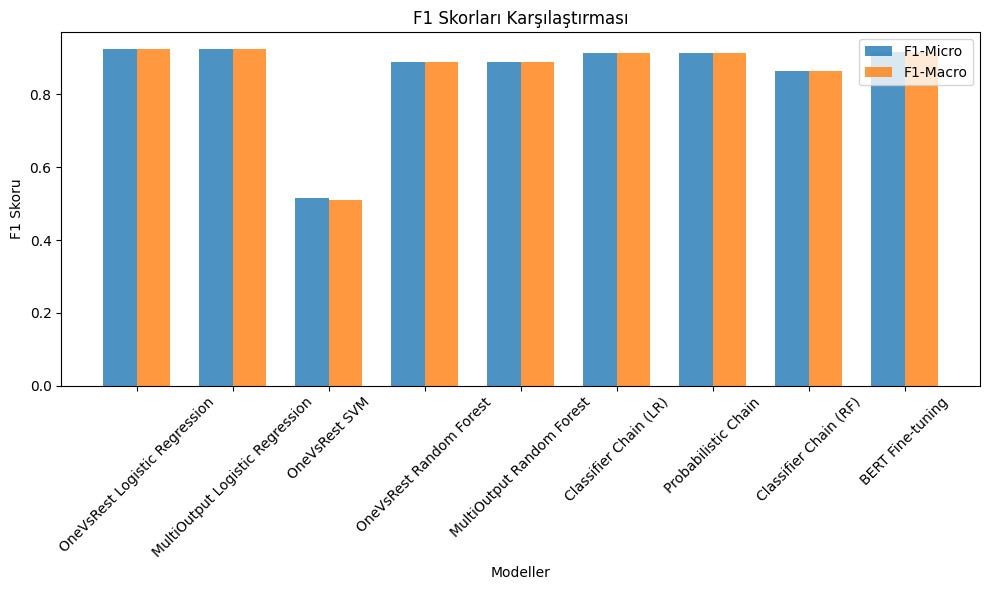

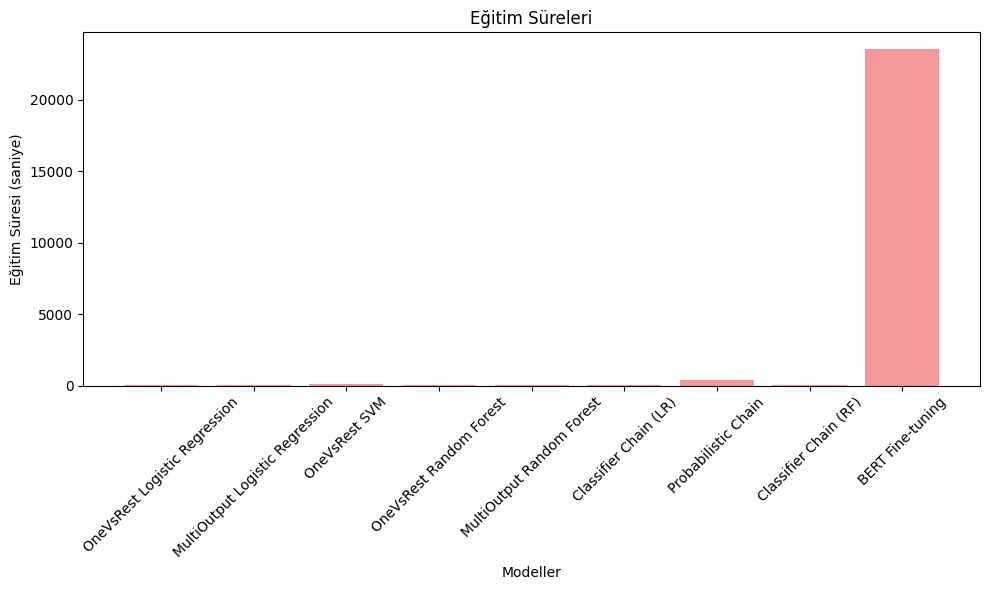

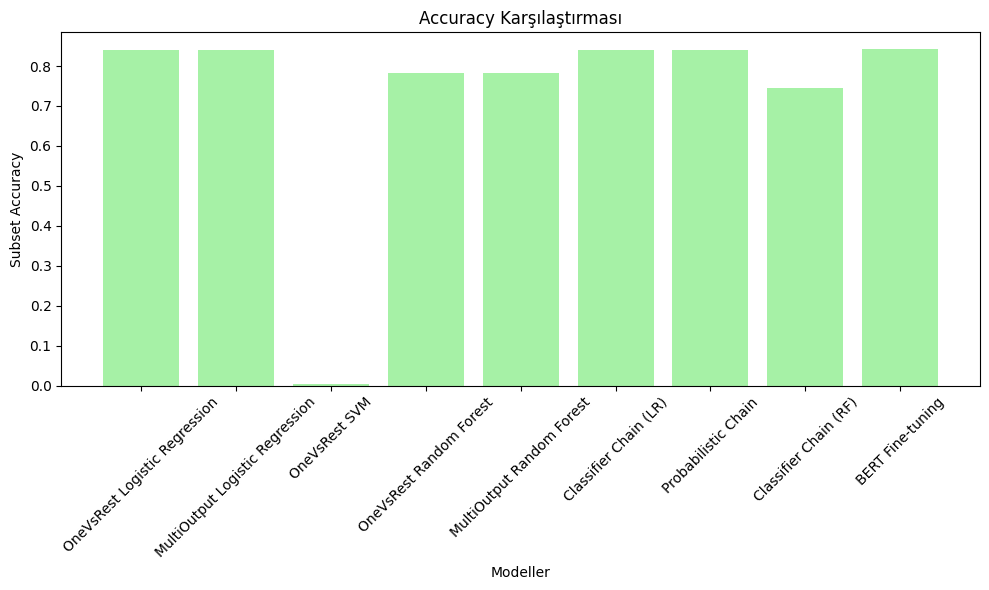

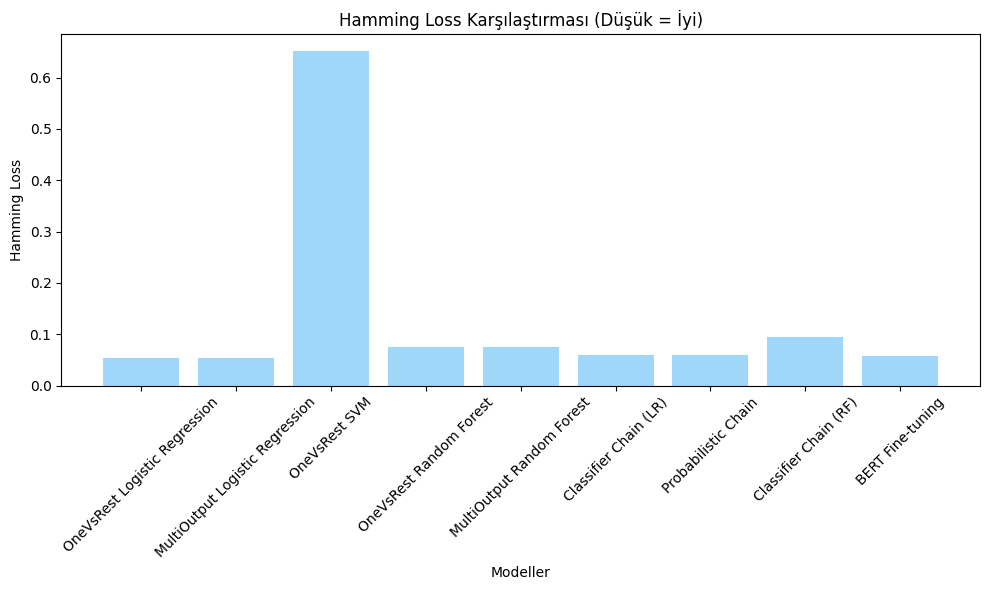

In [ ]:
# F1 skorlarƒ± kar≈üƒ±la≈ütƒ±rmasƒ±
plt.figure(figsize=(10, 6))
models = comparison_df['model']
f1_micro_scores = comparison_df['f1_micro']
f1_macro_scores = comparison_df['f1_macro']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, f1_micro_scores, width, label='F1-Micro', alpha=0.8)
plt.bar(x + width/2, f1_macro_scores, width, label='F1-Macro', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('F1 Skoru')
plt.title('F1 Skorlarƒ± Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('f1_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Eƒüitim s√ºreleri
plt.figure(figsize=(10, 6))
plt.bar(models, comparison_df['train_time'], color='lightcoral', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Eƒüitim S√ºresi (saniye)')
plt.title('Eƒüitim S√ºreleri')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('training_times.png', dpi=300, bbox_inches='tight')
plt.show()

# Accuracy kar≈üƒ±la≈ütƒ±rmasƒ±
plt.figure(figsize=(10, 6))
plt.bar(models, comparison_df['accuracy'], color='lightgreen', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Subset Accuracy')
plt.title('Accuracy Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Hamming Loss kar≈üƒ±la≈ütƒ±rmasƒ±
plt.figure(figsize=(10, 6))
plt.bar(models, comparison_df['hamming_loss'], color='lightskyblue', alpha=0.8)
plt.xlabel('Modeller')
plt.ylabel('Hamming Loss')
plt.title('Hamming Loss Kar≈üƒ±la≈ütƒ±rmasƒ± (D√º≈ü√ºk = ƒ∞yi)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('hamming_loss.png', dpi=300, bbox_inches='tight')
plt.show()

### Modelleri ayrƒ± ayrƒ± kaydet

In [ ]:
import os
import json
from datetime import datetime

# Ana models klas√∂r√º
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Timestamp ile alt klas√∂r
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
session_dir = os.path.join(models_dir, f'session_{timestamp}')
if not os.path.exists(session_dir):
    os.makedirs(session_dir)

print(f"Modeller ≈üu klas√∂re kaydediliyor: {session_dir}")

# Ba≈üarƒ±yla kaydedilen dosyalar listesi
saved_files = []
failed_files = []

# 1. TF-IDF Vectorizer'ƒ± kaydet
try:
    with open(os.path.join(session_dir, 'tfidf_vectorizer.pkl'), 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    saved_files.append('tfidf_vectorizer.pkl')
    print("‚úì TF-IDF Vectorizer kaydedildi")
except Exception as e:
    failed_files.append(f'tfidf_vectorizer.pkl: {str(e)}')
    print(f"‚ùå TF-IDF Vectorizer kaydetme hatasƒ±: {e}")

# 2. OneVsRest Logistic Regression modelini kaydet
try:
    with open(os.path.join(session_dir, 'ovr_logistic_regression.pkl'), 'wb') as f:
        pickle.dump(lr_ovr_model, f)
    saved_files.append('ovr_logistic_regression.pkl')
    print("‚úì OneVsRest Logistic Regression modeli kaydedildi")
except Exception as e:
    failed_files.append(f'ovr_logistic_regression.pkl: {str(e)}')
    print(f"‚ùå OneVsRest Logistic Regression kaydetme hatasƒ±: {e}")

# 2a. MultiOutput Logistic Regression modelini kaydet (kar≈üƒ±la≈ütƒ±rma i√ßin)
try:
    with open(os.path.join(session_dir, 'multi_logistic_regression.pkl'), 'wb') as f:
        pickle.dump(lr_multi_model, f)
    saved_files.append('multi_logistic_regression.pkl')
    print("‚úì MultiOutput Logistic Regression modeli kaydedildi")
except Exception as e:
    failed_files.append(f'multi_logistic_regression.pkl: {str(e)}')
    print(f"‚ùå MultiOutput Logistic Regression kaydetme hatasƒ±: {e}")

# 3. OneVsRest SVM modelini kaydet
try:
    with open(os.path.join(session_dir, 'ovr_svm.pkl'), 'wb') as f:
        pickle.dump(svm_ovr_model, f)
    saved_files.append('ovr_svm.pkl')
    print("‚úì OneVsRest SVM modeli kaydedildi")
except Exception as e:
    failed_files.append(f'ovr_svm.pkl: {str(e)}')
    print(f"‚ùå OneVsRest SVM kaydetme hatasƒ±: {e}")

# 4. OneVsRest Random Forest modelini kaydet
try:
    with open(os.path.join(session_dir, 'ovr_random_forest.pkl'), 'wb') as f:
        pickle.dump(rf_ovr_model, f)
    saved_files.append('ovr_random_forest.pkl')
    print("‚úì OneVsRest Random Forest modeli kaydedildi")
except Exception as e:
    failed_files.append(f'ovr_random_forest.pkl: {str(e)}')
    print(f"‚ùå OneVsRest Random Forest kaydetme hatasƒ±: {e}")

# 4a. MultiOutput Random Forest modelini kaydet (kar≈üƒ±la≈ütƒ±rma i√ßin)
try:
    with open(os.path.join(session_dir, 'multi_random_forest.pkl'), 'wb') as f:
        pickle.dump(rf_multi_model, f)
    saved_files.append('multi_random_forest.pkl')
    print("‚úì MultiOutput Random Forest modeli kaydedildi")
except Exception as e:
    failed_files.append(f'multi_random_forest.pkl: {str(e)}')
    print(f"‚ùå MultiOutput Random Forest kaydetme hatasƒ±: {e}")

# 4. Classifier Chain (LR) modelini kaydet
try:
    with open(os.path.join(session_dir, 'classifier_chain_lr.pkl'), 'wb') as f:
        pickle.dump(cc_lr_model, f)
    saved_files.append('classifier_chain_lr.pkl')
    print("‚úì Classifier Chain (LR) modeli kaydedildi")
except Exception as e:
    failed_files.append(f'classifier_chain_lr.pkl: {str(e)}')
    print(f"‚ùå Classifier Chain (LR) kaydetme hatasƒ±: {e}")

# 5. Probabilistic Chain modelini kaydet
try:
    with open(os.path.join(session_dir, 'probabilistic_chain.pkl'), 'wb') as f:
        pickle.dump(pcc_model, f)
    saved_files.append('probabilistic_chain.pkl')
    print("‚úì Probabilistic Chain modeli kaydedildi")
except Exception as e:
    failed_files.append(f'probabilistic_chain.pkl: {str(e)}')
    print(f"‚ùå Probabilistic Chain kaydetme hatasƒ±: {e}")

# 6. Classifier Chain (RF) modelini kaydet
try:
    with open(os.path.join(session_dir, 'classifier_chain_rf.pkl'), 'wb') as f:
        pickle.dump(cc_rf_model, f)
    saved_files.append('classifier_chain_rf.pkl')
    print("‚úì Classifier Chain (RF) modeli kaydedildi")
except Exception as e:
    failed_files.append(f'classifier_chain_rf.pkl: {str(e)}')
    print(f"‚ùå Classifier Chain (RF) kaydetme hatasƒ±: {e}")

# 7. Label columns'ƒ± ayrƒ± dosya olarak kaydet
try:
    with open(os.path.join(session_dir, 'label_columns.pkl'), 'wb') as f:
        pickle.dump(list(label_columns), f)
    saved_files.append('label_columns.pkl')
    print("‚úì Label columns kaydedildi")
except Exception as e:
    failed_files.append(f'label_columns.pkl: {str(e)}')
    print(f"‚ùå Label columns kaydetme hatasƒ±: {e}")

# 8. Performance results'ƒ± ayrƒ± dosya olarak kaydet
try:
    # Performance results'ƒ± temizle
    clean_performance = []
    for result in performance_results:
        clean_result = {}
        for key, value in result.items():
            if not callable(value):
                clean_result[key] = value
        clean_performance.append(clean_result)
    
    with open(os.path.join(session_dir, 'performance_results.pkl'), 'wb') as f:
        pickle.dump(clean_performance, f)
    saved_files.append('performance_results.pkl')
    print("‚úì Performance results kaydedildi")
except Exception as e:
    failed_files.append(f'performance_results.pkl: {str(e)}')
    print(f"‚ùå Performance results kaydetme hatasƒ±: {e}")

# 9. Correlation matrix'i ayrƒ± dosya olarak kaydet
try:
    with open(os.path.join(session_dir, 'correlation_matrix.pkl'), 'wb') as f:
        pickle.dump(correlation_matrix, f)
    saved_files.append('correlation_matrix.pkl')
    print("‚úì Correlation matrix kaydedildi")
except Exception as e:
    failed_files.append(f'correlation_matrix.pkl: {str(e)}')
    print(f"‚ùå Correlation matrix kaydetme hatasƒ±: {e}")

# 10. High correlation pairs'i ayrƒ± dosya olarak kaydet
try:
    with open(os.path.join(session_dir, 'high_corr_pairs.pkl'), 'wb') as f:
        pickle.dump(high_corr_pairs, f)
    saved_files.append('high_corr_pairs.pkl')
    print("‚úì High correlation pairs kaydedildi")
except Exception as e:
    failed_files.append(f'high_corr_pairs.pkl: {str(e)}')
    print(f"‚ùå High correlation pairs kaydetme hatasƒ±: {e}")

# 11. Model parametrelerini JSON olarak kaydet
try:
    model_params = {
        'max_features': max_features,
        'ngram_range': ngram_range,
        'min_df': min_df,
        'max_df': max_df,
        'test_size': test_size,
        'random_state': random_state,
        'preprocessing_info': {
            'description': 'Metin √∂n i≈üleme: k√º√ß√ºk harf + √∂zel karakter temizleme + bo≈üluk normalizasyonu',
            'pattern': r'[^a-zA-Z0-9\s]',
            'replacement': ' '
        }
    }
    
    with open(os.path.join(session_dir, 'model_parameters.json'), 'w', encoding='utf-8') as f:
        json.dump(model_params, f, indent=2, ensure_ascii=False)
    saved_files.append('model_parameters.json')
    print("‚úì Model parametreleri JSON olarak kaydedildi")
except Exception as e:
    failed_files.append(f'model_parameters.json: {str(e)}')
    print(f"‚ùå Model parametreleri kaydetme hatasƒ±: {e}")

# 12. BERT Fine-tuning modelini kaydet (eƒüer varsa)
if BERT_AVAILABLE and bert_pred is not None:
    try:
        with open(os.path.join(session_dir, 'bert_finetuned_model.pkl'), 'wb') as f:
            pickle.dump(bert_classifier, f)
        saved_files.append('bert_finetuned_model.pkl')
        print("‚úì BERT Fine-tuned modeli kaydedildi")
    except Exception as e:
        failed_files.append(f'bert_finetuned_model.pkl: {str(e)}')
        print(f"‚ùå BERT Fine-tuned modeli kaydetme hatasƒ±: {e}")
    
    try:
        with open(os.path.join(session_dir, 'bert_finetuned_tokenizer.pkl'), 'wb') as f:
            pickle.dump(bert_tokenizer, f)
        saved_files.append('bert_finetuned_tokenizer.pkl')
        print("‚úì BERT Fine-tuned tokenizer kaydedildi")
    except Exception as e:
        failed_files.append(f'bert_finetuned_tokenizer.pkl: {str(e)}')
        print(f"‚ùå BERT Fine-tuned tokenizer kaydetme hatasƒ±: {e}")
    
    # BERT Fine-tuner'ƒ± da kaydet
    try:
        with open(os.path.join(session_dir, 'bert_fine_tuner.pkl'), 'wb') as f:
            pickle.dump(bert_fine_tuner, f)
        saved_files.append('bert_fine_tuner.pkl')
        print("‚úì BERT Fine-tuner kaydedildi")
    except Exception as e:
        failed_files.append(f'bert_fine_tuner.pkl: {str(e)}')
        print(f"‚ùå BERT Fine-tuner kaydetme hatasƒ±: {e}")

Modeller ≈üu klas√∂re kaydediliyor: saved_models\session_20250826_070030
‚úì TF-IDF Vectorizer kaydedildi
‚úì OneVsRest Logistic Regression modeli kaydedildi
‚úì MultiOutput Logistic Regression modeli kaydedildi
‚úì OneVsRest SVM modeli kaydedildi
‚úì OneVsRest Random Forest modeli kaydedildi
‚úì MultiOutput Random Forest modeli kaydedildi
‚úì Classifier Chain (LR) modeli kaydedildi
‚úì Probabilistic Chain modeli kaydedildi
‚úì Classifier Chain (RF) modeli kaydedildi
‚úì Label columns kaydedildi
‚úì Performance results kaydedildi
‚úì Correlation matrix kaydedildi
‚úì High correlation pairs kaydedildi
‚úì Model parametreleri JSON olarak kaydedildi
‚úì BERT Fine-tuned modeli kaydedildi
‚úì BERT Fine-tuned tokenizer kaydedildi
‚úì BERT Fine-tuner kaydedildi


#### Kayƒ±t raporunu olu≈ütur

In [ ]:
save_report = {
    'timestamp': timestamp,
    'session_directory': session_dir,
    'total_files': len(saved_files) + len(failed_files),
    'successful_saves': len(saved_files),
    'failed_saves': len(failed_files),
    'saved_files': saved_files,
    'failed_files': failed_files
}

# Raporu JSON olarak kaydet
try:
    with open(os.path.join(session_dir, 'save_report.json'), 'w', encoding='utf-8') as f:
        json.dump(save_report, f, indent=2, ensure_ascii=False)
    print("‚úì Kayƒ±t raporu olu≈üturuldu")
except Exception as e:
    print(f"‚ùå Kayƒ±t raporu olu≈üturma hatasƒ±: {e}")

# √ñzet rapor
print(f"\n=== KAYIT √ñZETƒ∞ ===")
print(f"üìÅ Kayƒ±t klas√∂r√º: {session_dir}")
print(f"‚úÖ Ba≈üarƒ±lƒ±: {len(saved_files)} dosya")
print(f"‚ùå Ba≈üarƒ±sƒ±z: {len(failed_files)} dosya")

if saved_files:
    print(f"\nüìã Kaydedilen dosyalar:")
    for file in saved_files:
        print(f"  ‚úì {file}")

if failed_files:
    print(f"\n‚ö†Ô∏è Kaydedemediƒüi dosyalar:")
    for file in failed_files:
        print(f"  ‚ùå {file}")

print(f"\nüìä Toplam dosya boyutu:")
total_size = 0
for file in saved_files:
    try:
        file_path = os.path.join(session_dir, file)
        if os.path.exists(file_path):
            size = os.path.getsize(file_path)
            total_size += size
            print(f"  {file}: {size/1024/1024:.2f} MB")
    except:
        continue

print(f"üì¶ Toplam: {total_size/1024/1024:.2f} MB")



‚úì Kayƒ±t raporu olu≈üturuldu

=== KAYIT √ñZETƒ∞ ===
üìÅ Kayƒ±t klas√∂r√º: saved_models\session_20250826_070030
‚úÖ Ba≈üarƒ±lƒ±: 17 dosya
‚ùå Ba≈üarƒ±sƒ±z: 0 dosya

üìã Kaydedilen dosyalar:
  ‚úì tfidf_vectorizer.pkl
  ‚úì ovr_logistic_regression.pkl
  ‚úì multi_logistic_regression.pkl
  ‚úì ovr_svm.pkl
  ‚úì ovr_random_forest.pkl
  ‚úì multi_random_forest.pkl
  ‚úì classifier_chain_lr.pkl
  ‚úì probabilistic_chain.pkl
  ‚úì classifier_chain_rf.pkl
  ‚úì label_columns.pkl
  ‚úì performance_results.pkl
  ‚úì correlation_matrix.pkl
  ‚úì high_corr_pairs.pkl
  ‚úì model_parameters.json
  ‚úì bert_finetuned_model.pkl
  ‚úì bert_finetuned_tokenizer.pkl
  ‚úì bert_fine_tuner.pkl

üìä Toplam dosya boyutu:
  tfidf_vectorizer.pkl: 1.91 MB
  ovr_logistic_regression.pkl: 1.53 MB
  multi_logistic_regression.pkl: 1.53 MB
  ovr_svm.pkl: 4.42 MB
  ovr_random_forest.pkl: 40.02 MB
  multi_random_forest.pkl: 40.02 MB
  classifier_chain_lr.pkl: 1.53 MB
  probabilistic_chain.pkl: 1.53 MB
  classifier_